In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("ksi_collisions.csv")

In [3]:
df.sample(2)

,DATE,STREET1,STREET2,DISTRICT,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,ROAD_CONDITION,ACCLASS,...,HOUR,YEAR,MONTH,SEVERE_COLLISION,TIME_OF_DAY,SEASON,VEHICLE_TYPE,DRIVER_ACTION,IMPACT_TYPE,AGE_RANGE
15247,2019-05-05,1140 SHEPPARD AVE W,NaN,North York,43.753180,-79.468578,Clear,Daylight,Dry,Non-Fatal Injury,...,15,2019,5,1,Evening,Spring,Car,Right-of-Way/Traffic Violation,T-Bone,50–59
6264,2010-10-04,BLOOR ST W,DUNDAS ST W,Toronto and East York,43.656345,-79.452490,Clear,Daylight,Dry,Non-Fatal Injury,...,11,2010,10,1,MorningAfternoon,Fall,Car,Other/Unknown,Pedestrian/Cyclist,10–19


In [4]:
categorical_features = ['LIGHT', 'VISIBILITY', 'ROAD_CONDITION', 'DOW', 'TIME_OF_DAY',
                        'SEASON', 'VEHICLE_TYPE', 'DRIVER_ACTION', 'IMPACT_TYPE', 'NEIGHBOURHOOD', 'AGE_RANGE']

In [5]:
target = 'SEVERE_COLLISION'

In [6]:
X = df[categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=85,
        max_depth=24,
        max_features = 'sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [8]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      2900
           1       0.72      0.69      0.70      2680

    accuracy                           0.72      5580
   macro avg       0.72      0.72      0.72      5580
weighted avg       0.72      0.72      0.72      5580



In [10]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

Train accuracy: 0.837
Test accuracy: 0.720


In [11]:
valid_categories = {
    col: set(X_train[col].dropna().unique())
    for col in categorical_features
}

print(valid_categories)

{'LIGHT': {'Daylight', 'Twilight', 'Dark'}, 'VISIBILITY': {'Clear', 'Rain', 'Snow'}, 'ROAD_CONDITION': {'Wet', 'SnowIce', 'Dry'}, 'DOW': {'Wednesday', 'Sunday', 'Tuesday', 'Thursday', 'Monday', 'Friday', 'Saturday'}, 'TIME_OF_DAY': {'Night', 'LateNight', 'MorningAfternoon', 'Evening'}, 'SEASON': {'Summer', 'Fall', 'Spring', 'Winter'}, 'VEHICLE_TYPE': {'Bus', 'Two Wheeler', 'Car', 'Emergency', 'Truck'}, 'DRIVER_ACTION': {'Right-of-Way/Traffic Violation', 'Control/Maneuver Error', 'Speed-Related', 'Other/Unknown'}, 'IMPACT_TYPE': {'T-Bone', 'Pedestrian/Cyclist', 'Sideswipe/Approaching', 'Rear End', 'Slow/Parked'}, 'NEIGHBOURHOOD': {'Yonge-Eglinton', 'Maple Leaf', 'Mimico-Queensway', 'Humber Heights-Westmount', 'Banbury-Don Mills', 'Corso Italia-Davenport', 'Yonge-Doris', 'Agincourt North', 'Centennial Scarborough', 'Henry Farm', 'Bay-Cloverhill', 'Englemount-Lawrence', 'Downtown Yonge East', 'Eringate-Centennial-West Deane', 'Lambton Baby Point', 'South Parkdale', 'High Park North', 'Mou

In [12]:
#save model
joblib.dump({
    "model": model,
    "feature_values": valid_categories
}, "model.joblib")

['model.joblib']

In [13]:
y_proba = model.predict_proba(df)[:, 1]

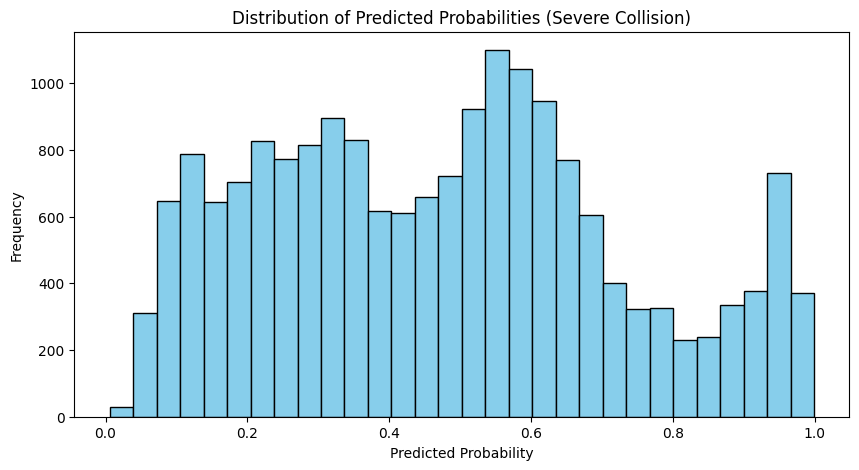

In [14]:
plt.figure(figsize=(10,5))
plt.hist(y_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Severe Collision)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

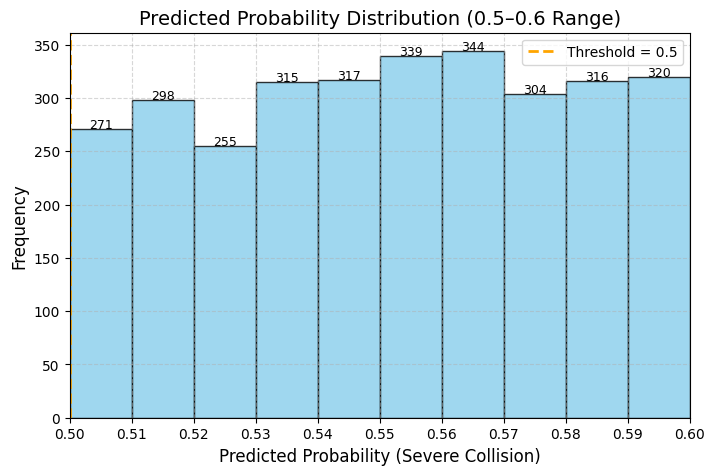

In [15]:
bins = np.arange(0.5, 0.61, 0.01)

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(
    y_proba, bins=bins, color='skyblue', edgecolor='black', alpha=0.8
)

plt.title("Predicted Probability Distribution (0.5–0.6 Range)", fontsize=14)
plt.xlabel("Predicted Probability (Severe Collision)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for i, count in enumerate(counts):
    plt.text(bins[i] + 0.005, count + 0.5, str(int(count)), ha='center', fontsize=9)

plt.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.5')

plt.xlim(0.5, 0.6)
plt.xticks(np.arange(0.5, 0.61, 0.01))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()